import

In [1]:
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import math

from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange

import warnings
warnings.filterwarnings("ignore")

from myhelpers import config_plots, TrialStatistics
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName, getDatasetName
from flashtorch_modefied import CNN_wrapper, Backprop, SaliencyMap

config_plots.global_settings()

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish"
experimentName="biology_paper_easy_curated4_Easy_smaller"
trial_hash="29ff9b40ebac1251756a4b178d19c9e4c8cd2124f4ecde33f5b52edb" #BB
# trial_hash="ae083d3077841b2d44efe1bbd9a1878968c4bc54ad495a777d66a7cd" #HGNN

# trial_hash="ab11ba1883ce9ff78462669947ddb5f9ad3bc0d325f0ade76c7515b0" #BB
# trial_hash="9f3023b0d894625d8a7e53590ca94f1179a9d0e7a7656085c173ba54" #HGNN

cuda=0

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 0


importLoad experiment

In [4]:
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

experimentPathAndName = os.path.join(experimentsPath, experimentName)

datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

paramsIterator = config_parser.getExperiments()  
number_of_experiments = sum(1 for e in paramsIterator)  

load dataset and model

In [5]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
experiment_params = config_parser.fixExperimentParams(experiment_params)

# This is needed to get saliency map for a model that does not do back propagation.
experiment_params['noSpeciesBackprop'] = False 

if math.isnan(experiment_params['suffix']):
    experiment_params['suffix'] = None
print(experiment_params)

# Create the model
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders()
fineList = test_loader.dataset.csv_processor.getFineList()
coarseList = test_loader.dataset.csv_processor.getCoarseList()
numberOffine = len(fineList)
numberOfcoarse = len(coarseList)
architecture = {
    "fine": numberOffine,
    "coarse" : numberOfcoarse
}
model = CNN.create_model(architecture, experiment_params, device=cuda)

{'experimentName': 'biology_paper_easy_curated4_Easy_smaller', 'modelName': 'models/29ff9b40ebac1251756a4b178d19c9e4c8cd2124f4ecde33f5b52edb', 'datasetName': 'datasplits/7c7513bdfb4e5577fef1c3ec0fa6452d30d87dbc95f258a7c86dd76b', 'experimentHash': 'a34fd211dd815588f94bc4b82f71091d824df75b0379c883de362994', 'trialHash': '29ff9b40ebac1251756a4b178d19c9e4c8cd2124f4ecde33f5b52edb', 'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.0001, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.01, 'adaptive_alpha': 0.9, 'noSpeciesBackprop': False, 'phylogeny_loss': False, 'phylogeny_loss_epsilon': 0.03, 'tripletEnabled': nan, 'tripletSamples': nan, 'tripletSelector': nan, 'tripletMargin': nan, 'displayName': nan, 'pretrained': nan, 'epochs': nan, 'patience': nan, 'optimizer': nan, 'sch

Load model of a specific trial

In [6]:
# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)

df, epochs, time_elapsed = CNN.loadModel(model, trialName, device=cuda)

Model wrapper

In [7]:
wrapped_model = CNN_wrapper(model, experiment_params, test_loader.dataset)

Saliency map of one image

In [8]:
# params
wrapped_model.setOutputsOfInterest({
    "fine": True,
    "coarse" : False
})
# fileName= '/raid/elhamod/Fish/Curated3/Medium/curated_30_50/test/Luxilus cornutus/43066_lat_FMNH_FZ_m.jpg'
# fileName='/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis nubilus/INHS_FISH_82467.jpg'
# fileName='/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis nubilus/INHS_FISH_80599.jpg'
# fileName='/raid/elhamod/Fish/Curated4/Medium/curated_30_50/test/Noturus eleutherus/INHS_FISH_16862.jpg'
# fileName = '/raid/elhamod/Fish/Curated4/Medium/curated_30_50/test/Cottus carolinae/UWZM-F-0004463.JPG'
# fileName= '/raid/elhamod/Fish/Curated3/Medium/curated_30_50/test/Luxilus cornutus/43066_lat_FMNH_FZ_m.jpg'

# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Carassius auratus/INHS_FISH_16124.jpg'

# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Noturus nocturnus/INHS_FISH_32148.jpg'
# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Phenacobius mirabilis/INHS_FISH_73996.jpg'
# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Phenacobius mirabilis/INHS_FISH_8554.jpg'

# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Noturus gyrinus/INHS_FISH_29582.jpg'
# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis percobromus/INHS_FISH_81238.jpg'
# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis percobromus/INHS_FISH_23650.jpg'
fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis nubilus/INHS_FISH_81913.jpg'
# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis nubilus/INHS_FISH_80599.jpg'

# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis leuciodus/INHS_FISH_109185.jpg'

# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis buccatus/INHS_FISH_92297.jpg'
# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Lepomis gulosus/INHS_FISH_25410.jpg'

# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Carassius auratus/INHS_FISH_000835.jpg'




# fileName='/raid/elhamod/Fish/Curated4/Medium/curated_30_50/test/Alosa chrysochloris/100788_lat_FMNH_FZ.jpg'

layerName = "fine"
# "input": x,
# "hy_features": hy_features,
# "hb_features": hb_features,
# "gy_features": gy_features if outputs["fine"] else None,
# "gc_features": gc_features if outputs["coarse"] else None,
# "coarse": yc if outputs["coarse"] and modelType_has_coarse else None,
# "fine": y if outputs["fine"] else None

Number of activations:  torch.Size([1, 38])


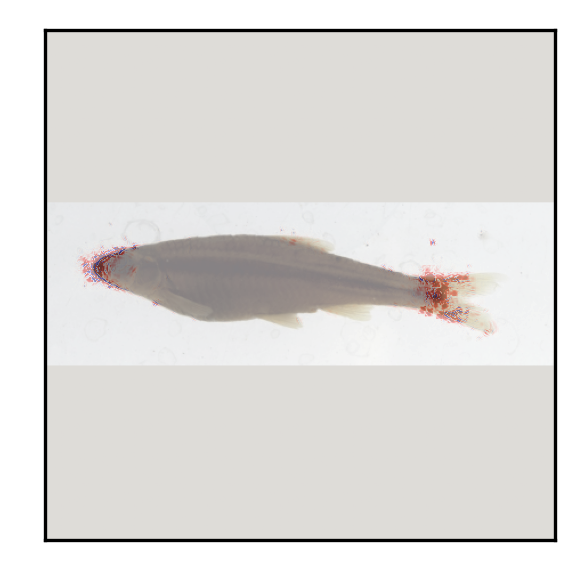

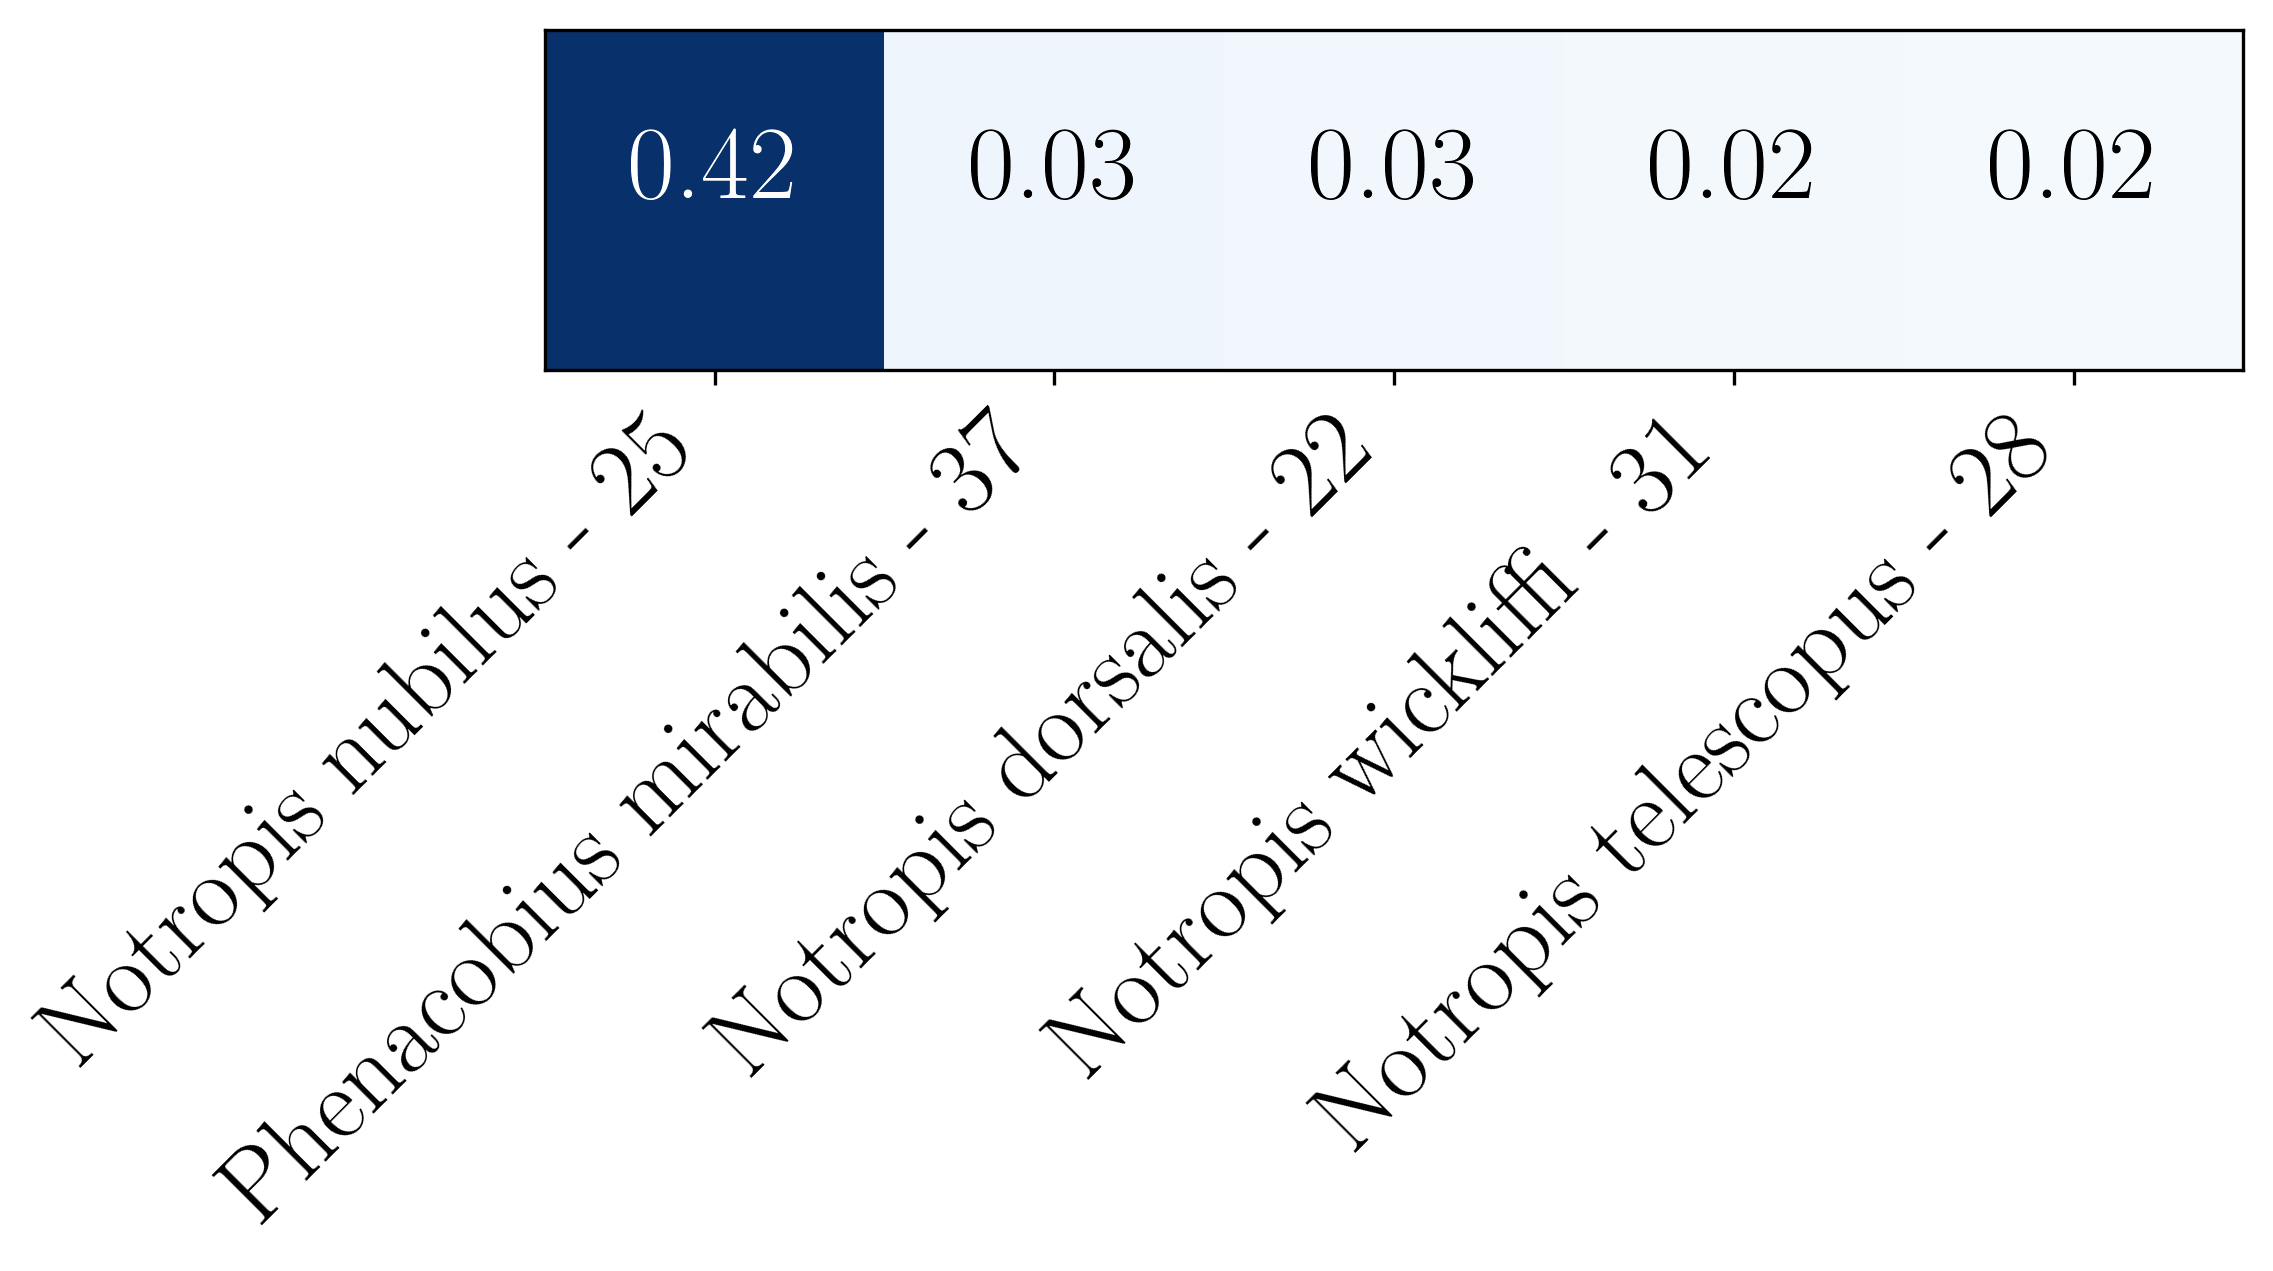

In [9]:
# %%capture
import os
from torchvision import transforms as torchvision_transforms
from skimage import io

saliencyMap = SaliencyMap(test_loader.dataset, wrapped_model, experimentPathAndName, trial_hash, experiment_params)
_, _ = saliencyMap.GetSaliencyMap(fileName, layerName, use_gpu=True)

box_width =  49
Number of activations:  torch.Size([1, 38])


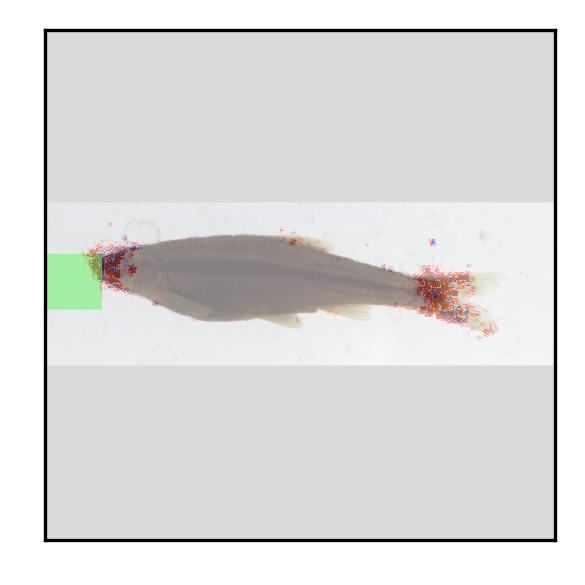

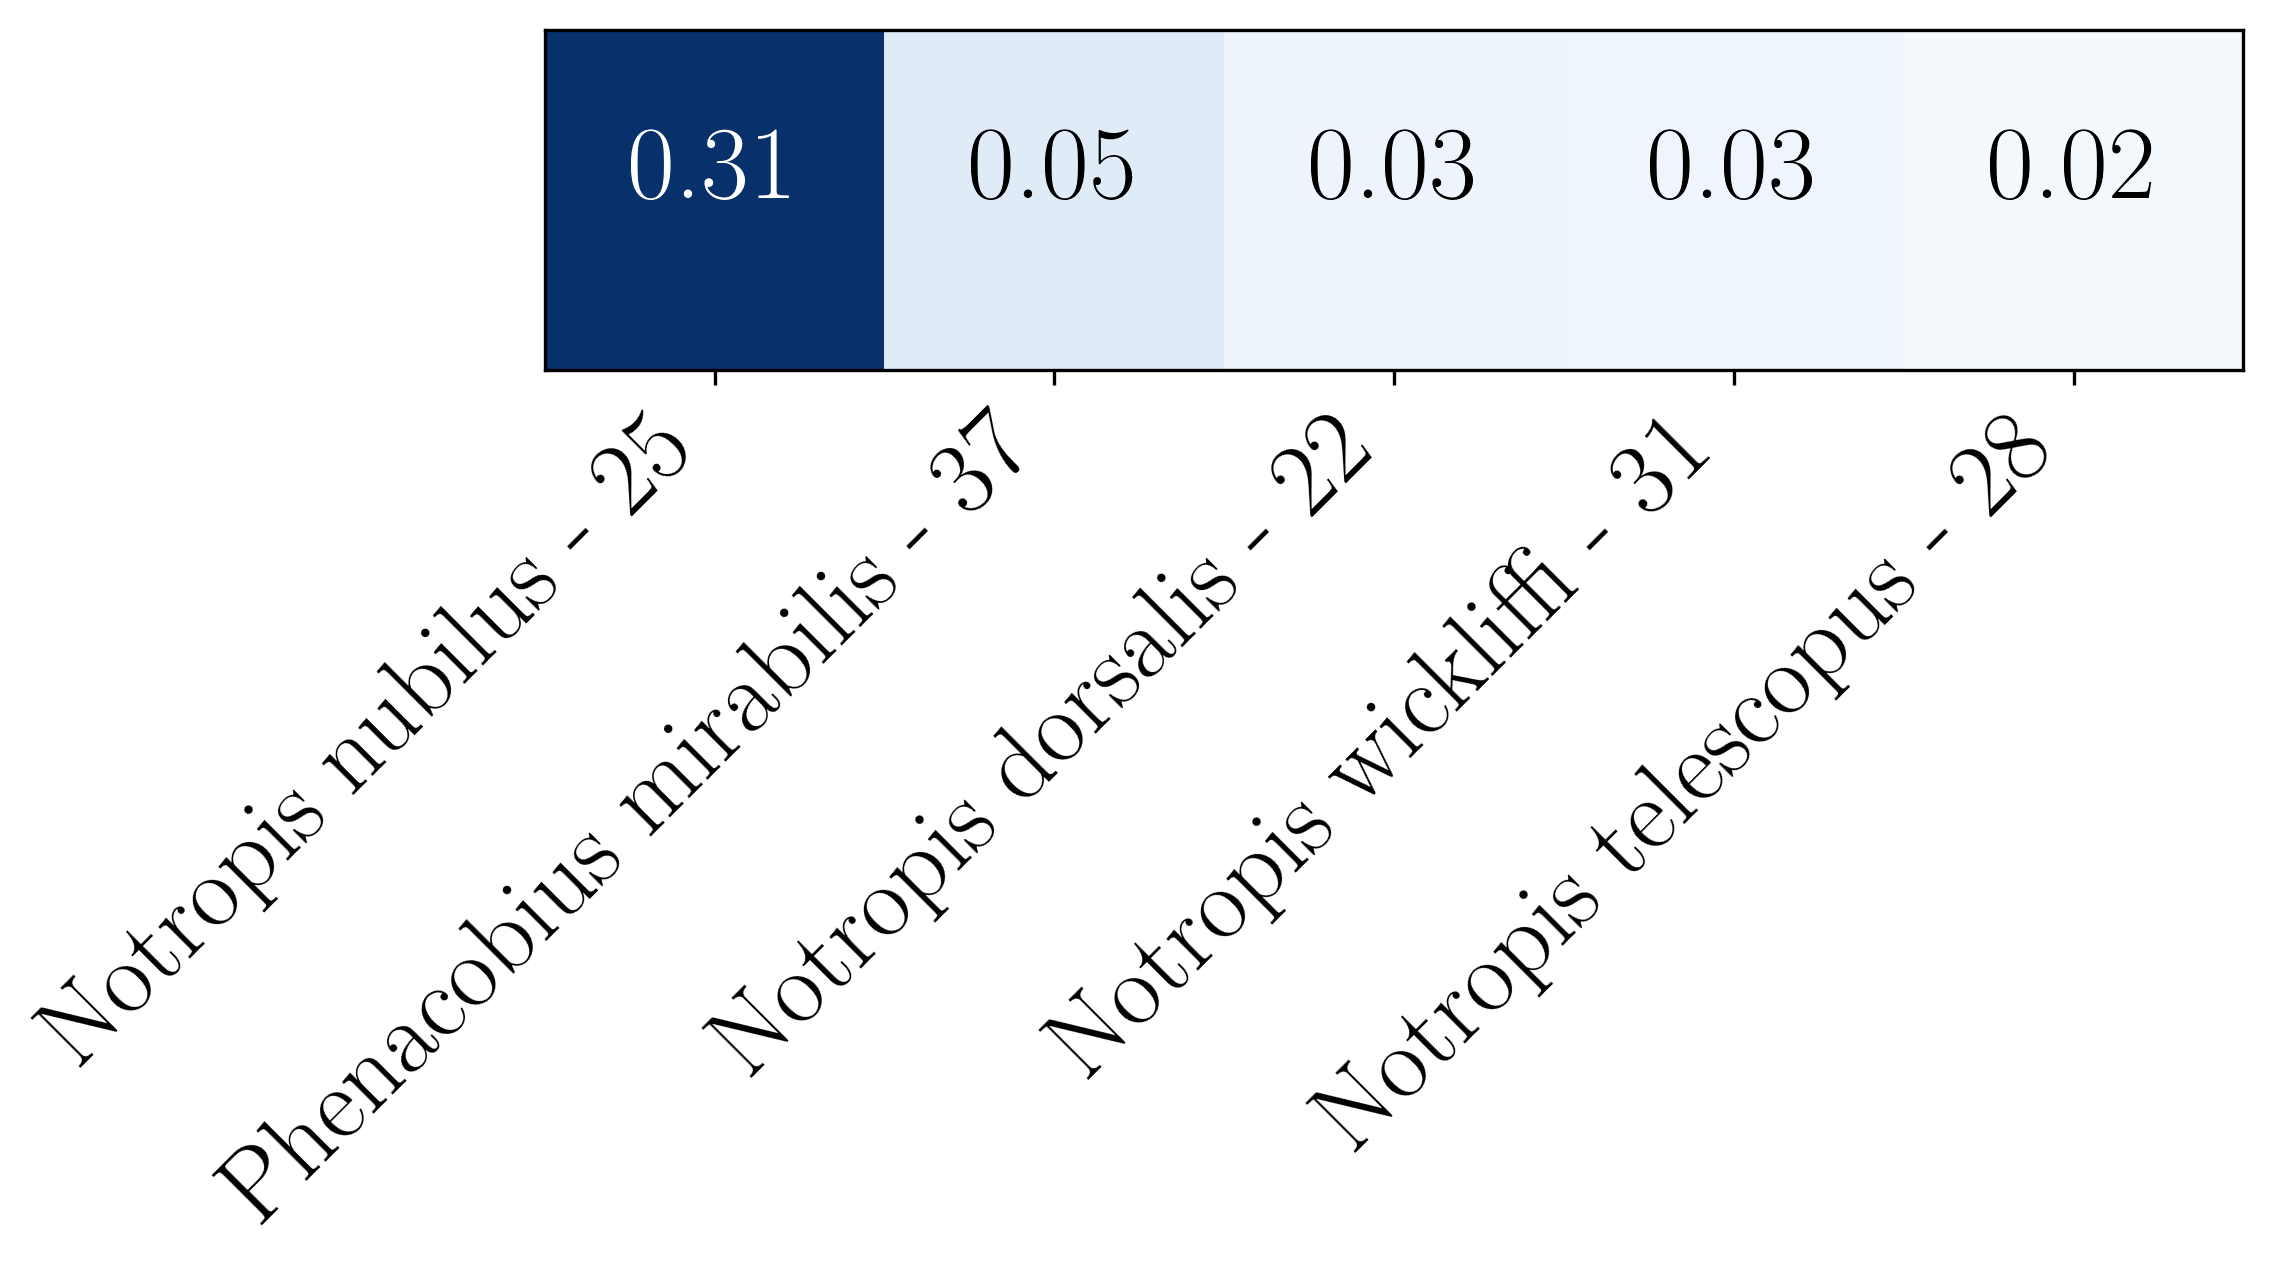

Number of activations:  torch.Size([1, 38])


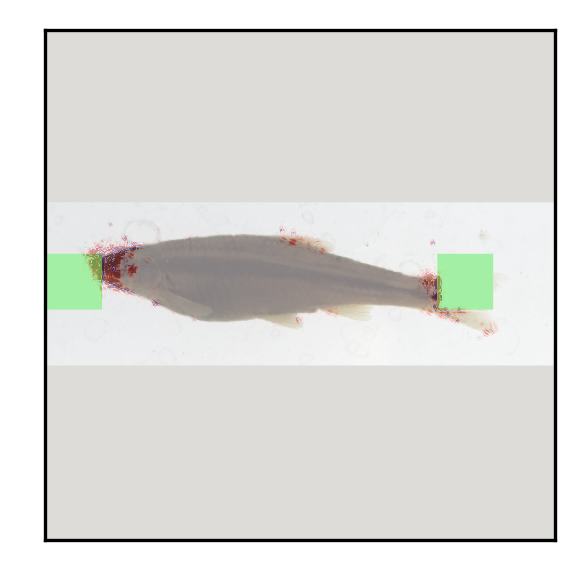

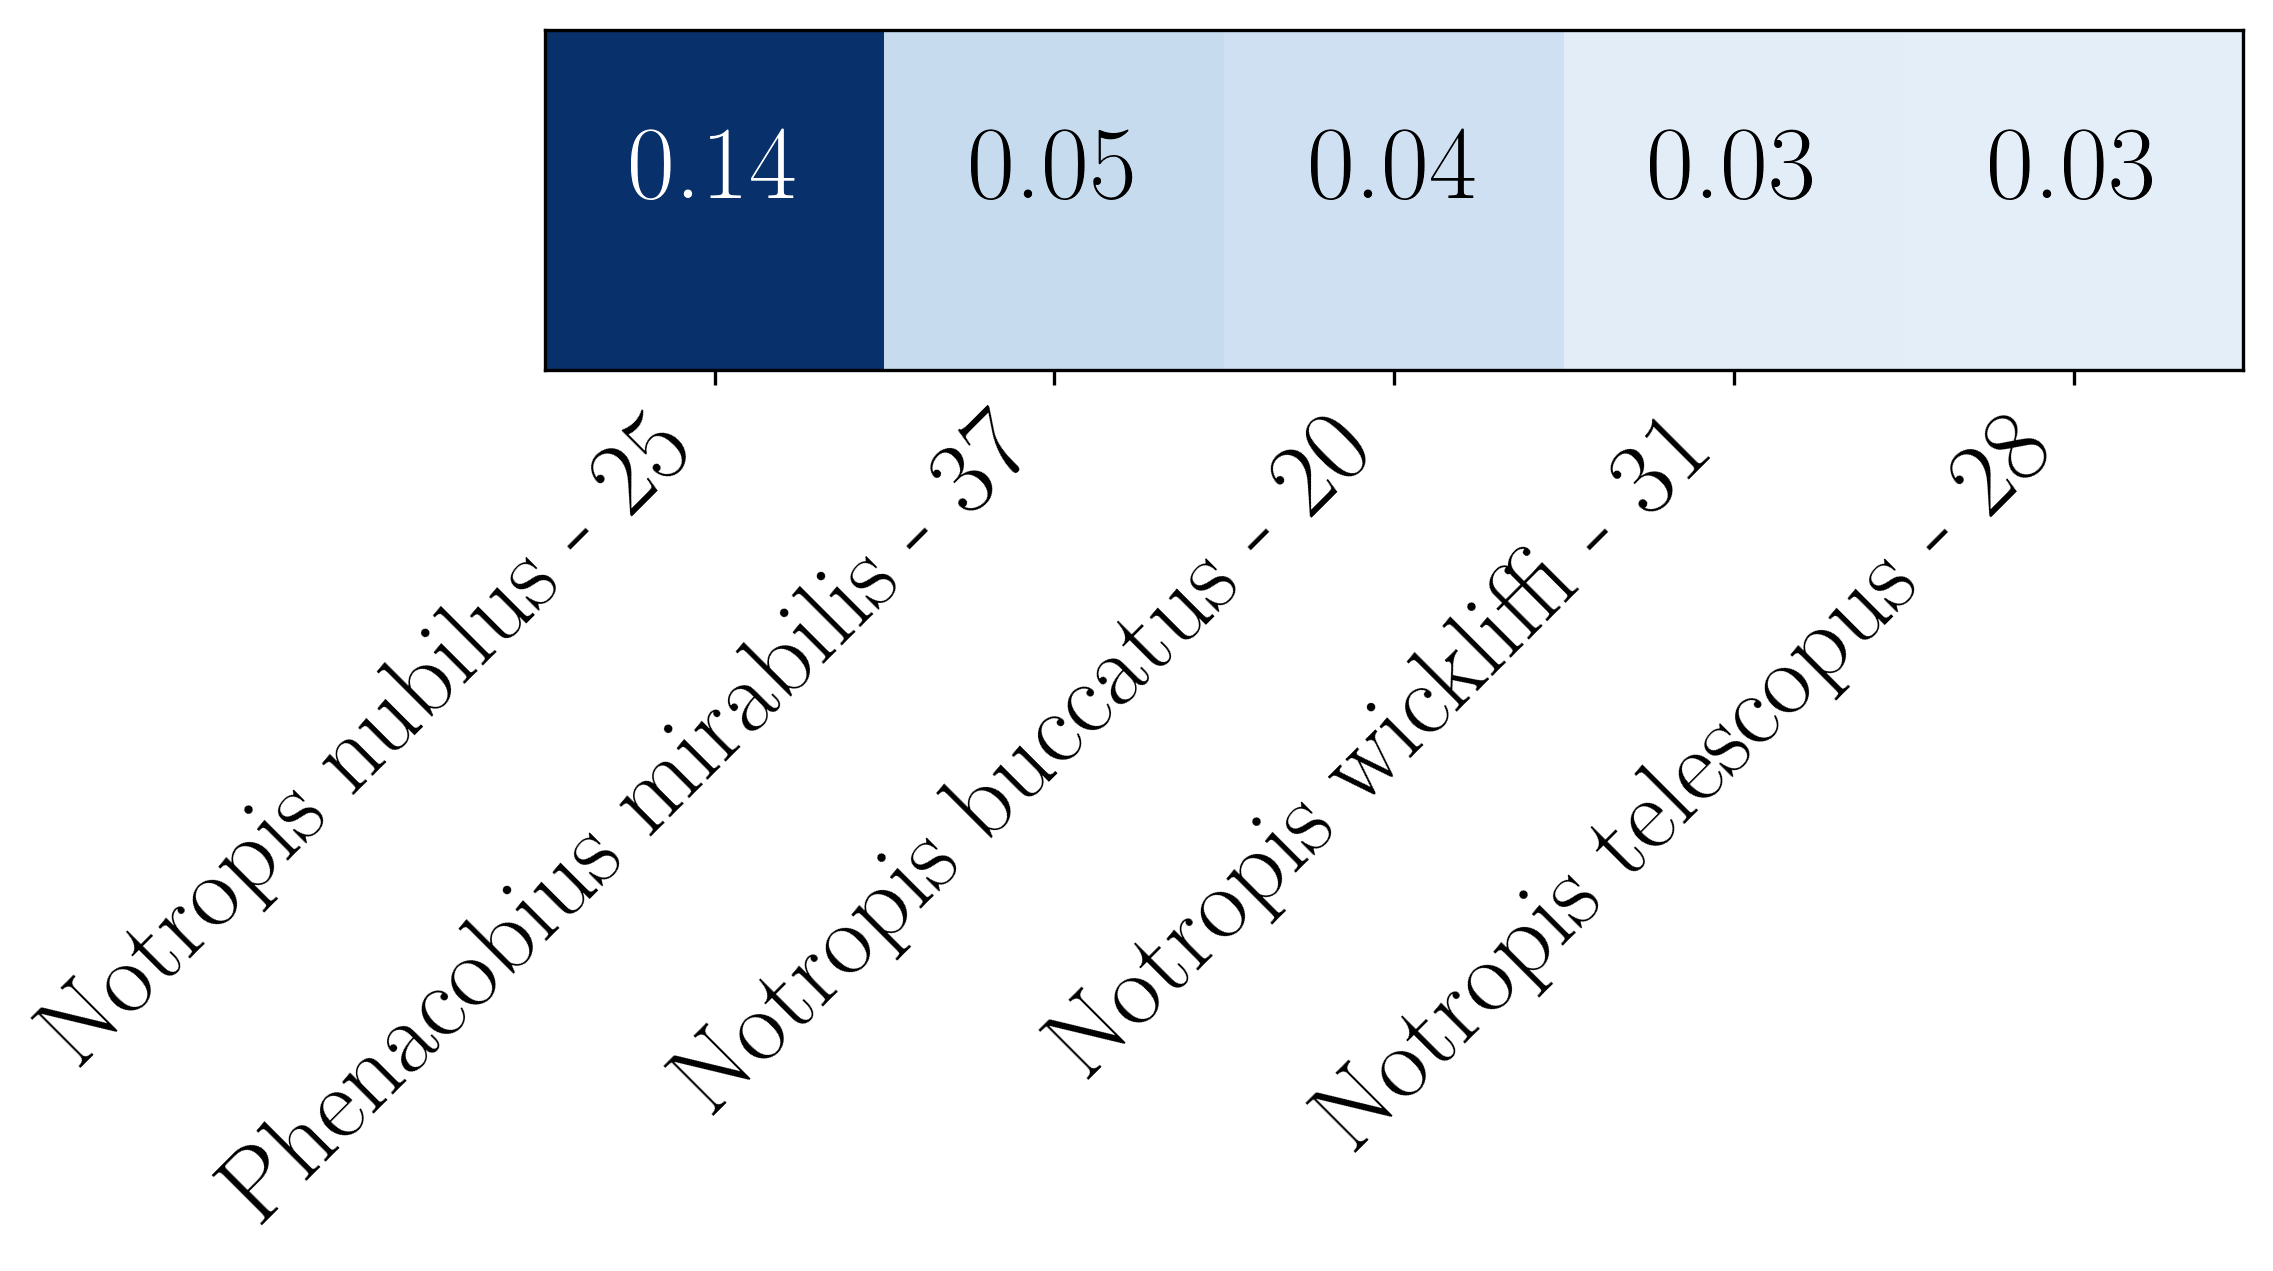

Number of activations:  torch.Size([1, 38])


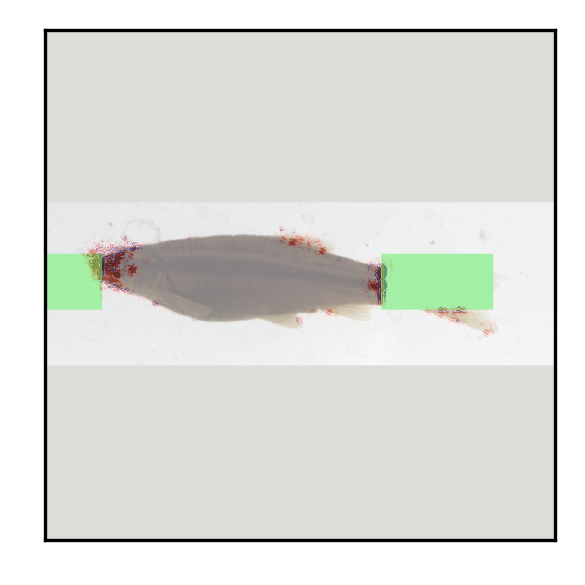

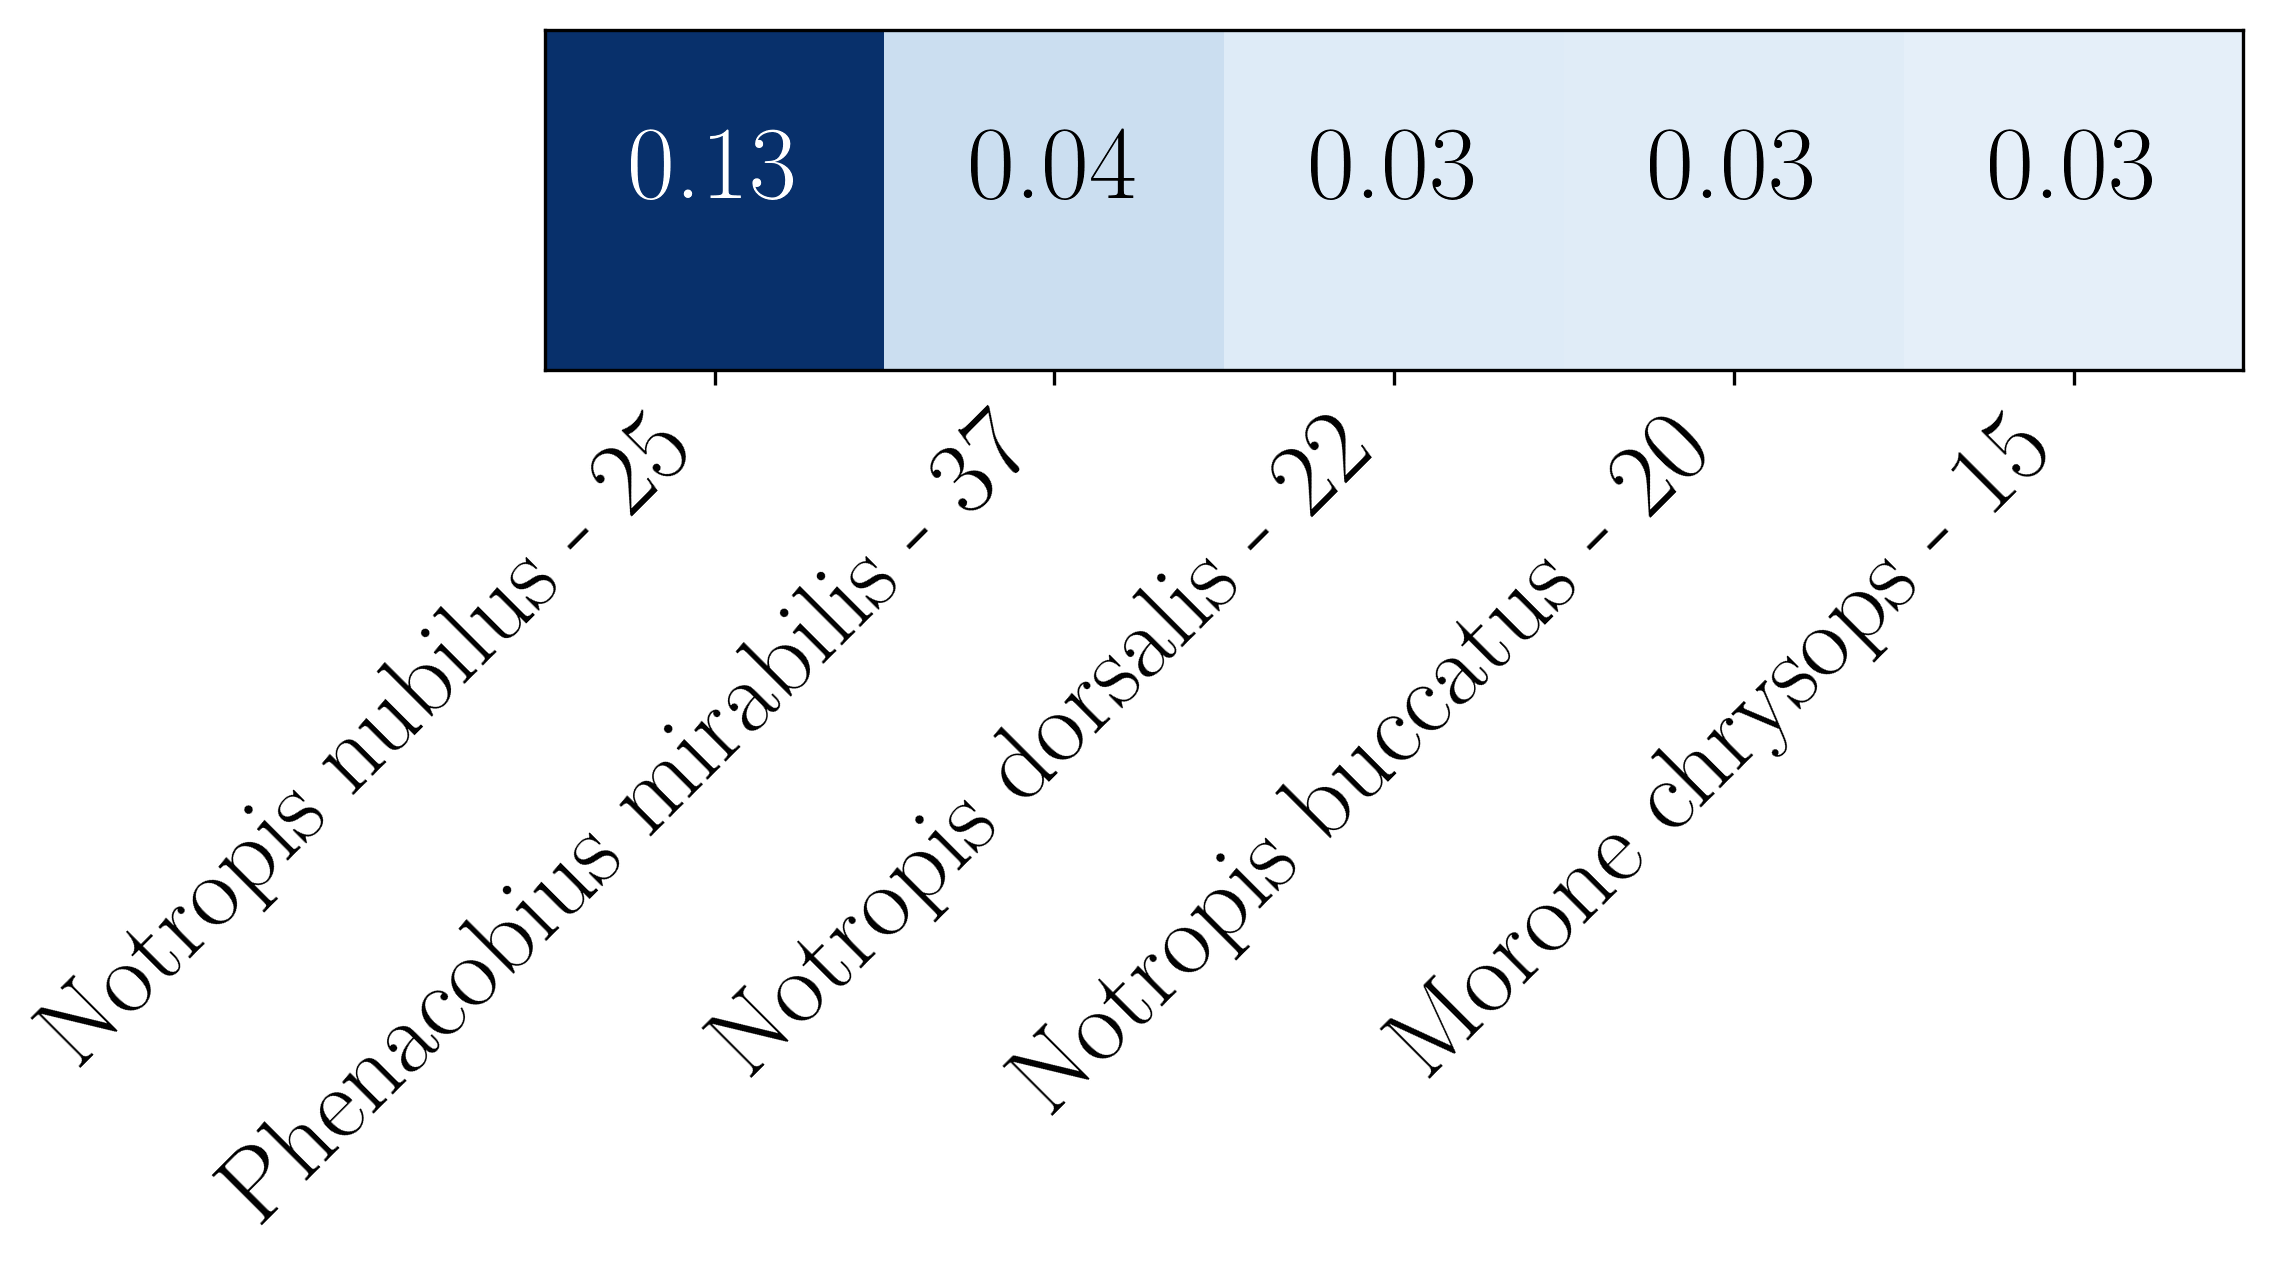

Number of activations:  torch.Size([1, 38])


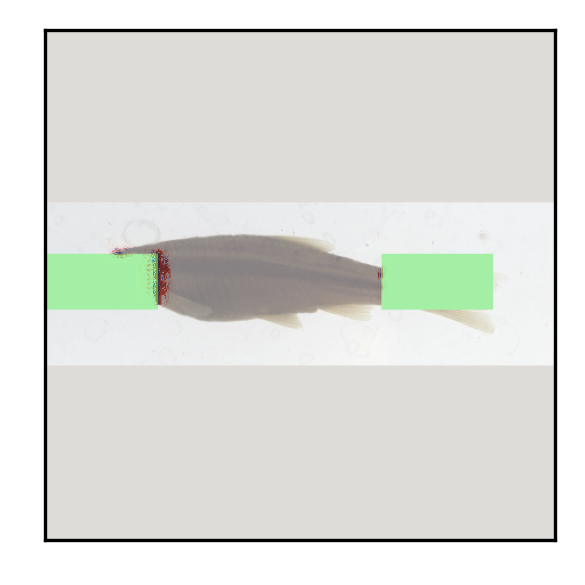

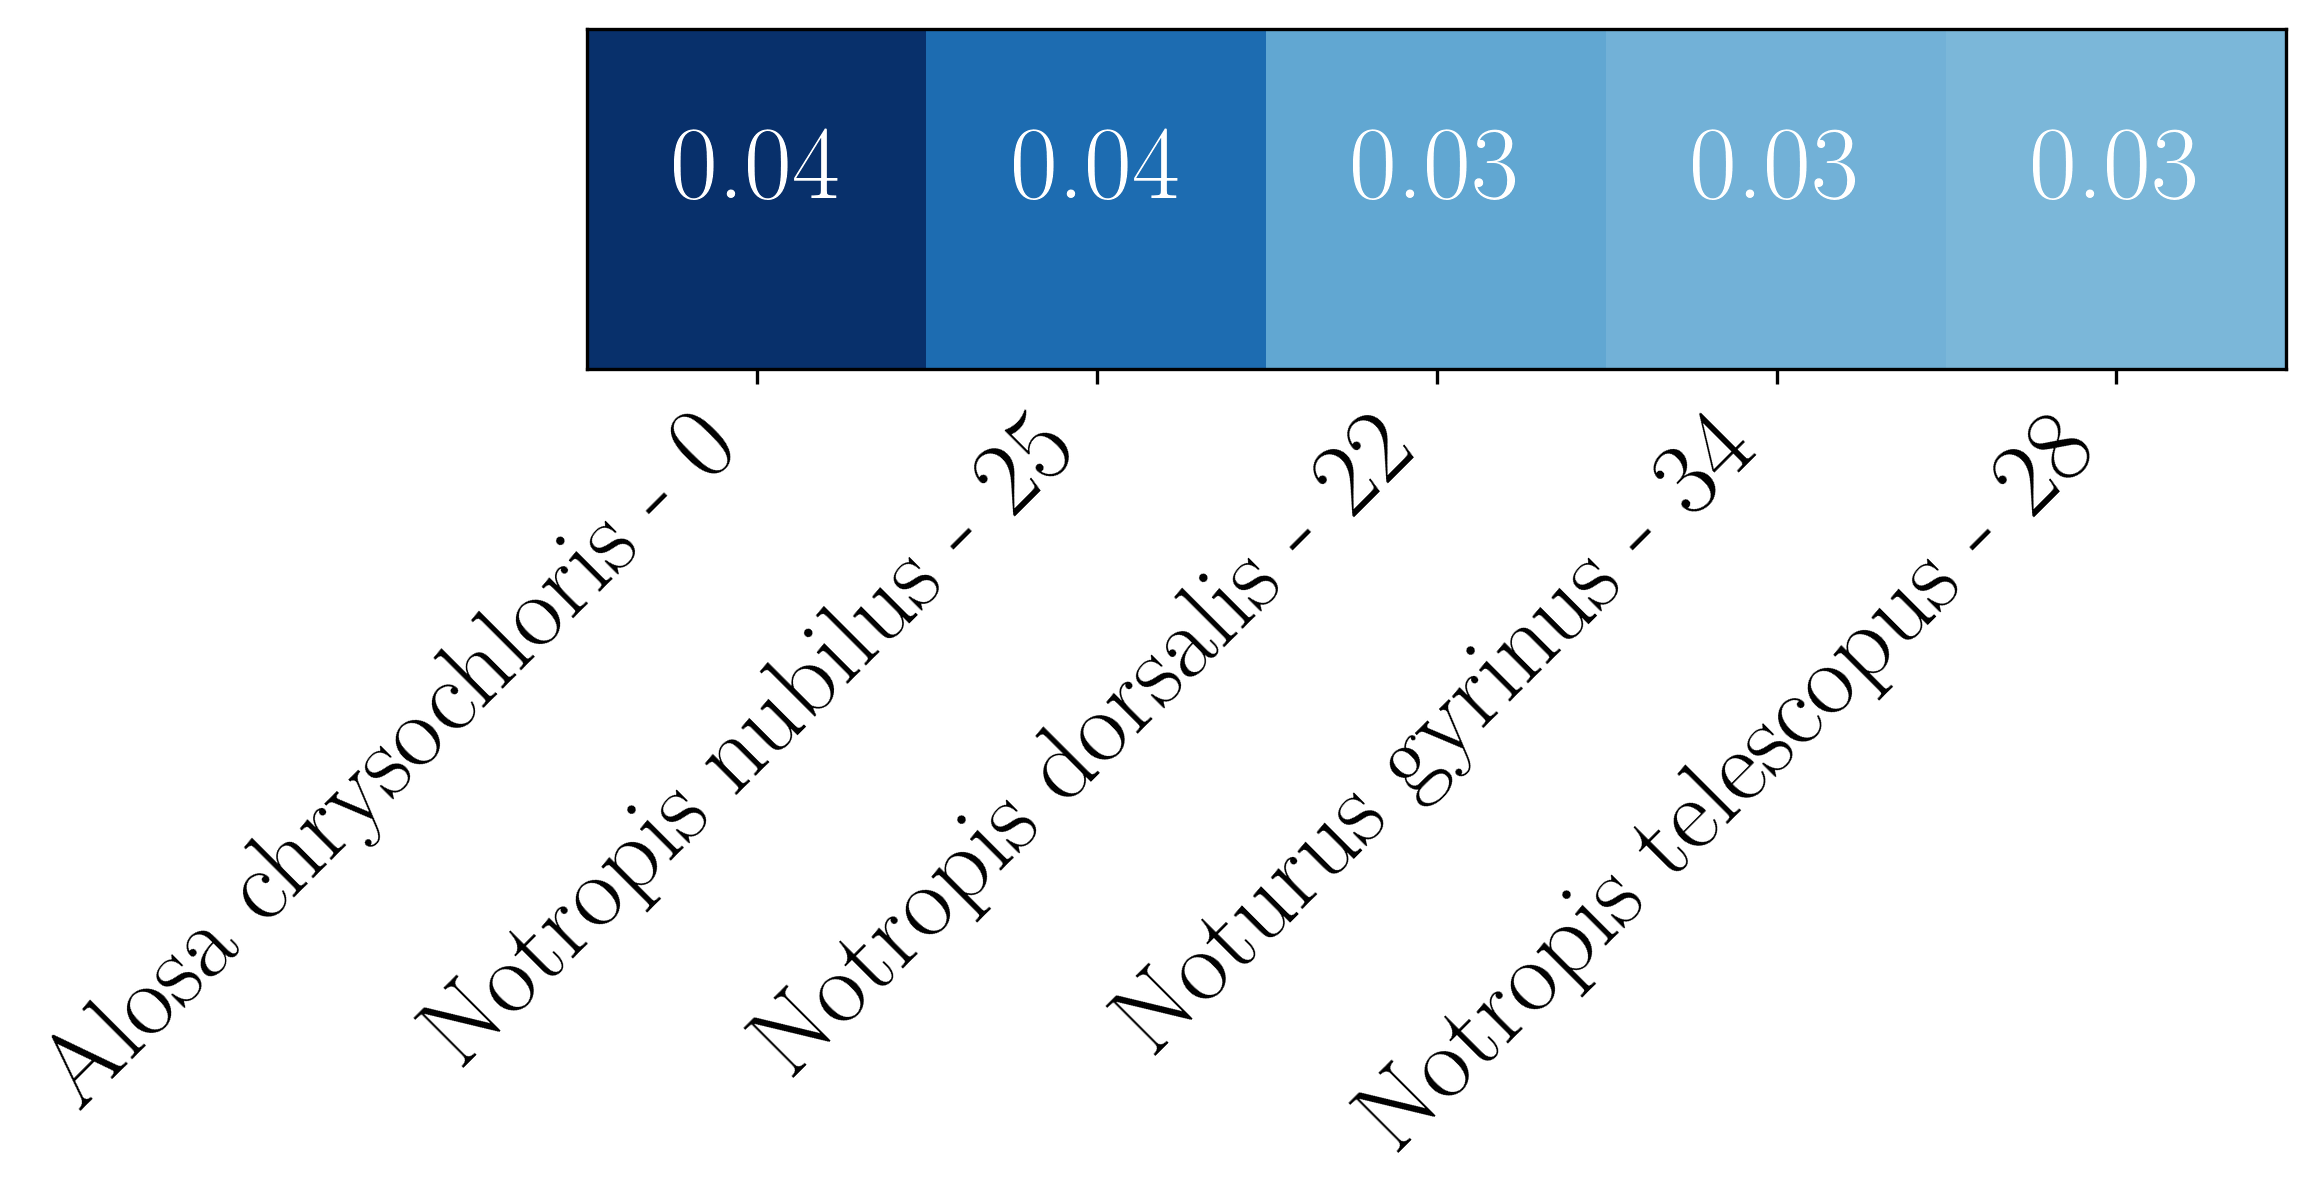

In [10]:
for i in [49]: #9, 19, 29 ,39 ,
    print('box_width = ', i)
    saliencyMap.GetSaliencyMap(fileName,layerName,box_width =i, maxCovered=True, topk=4, use_gpu=True)

List of test images of a certain species

In [11]:
# params
species = 0
###################

train_loader, validation_loader, test_loader = datasetManager.getLoaders()
loader = train_loader

lst = []
for batch in loader:
    lst = lst + [batch['fileName'][indx] for (indx, i) in enumerate(batch['fine']) if i == species]
print(lst)

Creating loaders...
Creating loaders... Done.
['INHS_FISH_54478.JPG', 'INHS_FISH_97665.JPG', 'INHS_FISH_24800.JPG', 'INHS_FISH_100088.JPG', 'INHS_FISH_91608.JPG', 'INHS_FISH_935.JPG', 'INHS_FISH_24054.JPG', 'INHS_FISH_5773.JPG', 'INHS_FISH_64133.JPG', 'INHS_FISH_14000.JPG', 'INHS_FISH_48605.JPG', 'INHS_FISH_25842.JPG', 'INHS_FISH_38467.JPG', 'INHS_FISH_26459.JPG', 'INHS_FISH_42475.JPG', 'INHS_FISH_99251.JPG', 'INHS_FISH_38910.JPG', 'INHS_FISH_95164.JPG', 'INHS_FISH_106314.JPG', 'INHS_FISH_1447.JPG', 'INHS_FISH_99256.JPG', 'INHS_FISH_1157.JPG', 'INHS_FISH_5837.JPG', 'INHS_FISH_100477.JPG', 'INHS_FISH_19736.JPG', 'INHS_FISH_73683.JPG', 'INHS_FISH_48349.JPG', 'INHS_FISH_56969.JPG', 'INHS_FISH_48517.JPG', 'INHS_FISH_90360.JPG', 'INHS_FISH_49982.JPG', 'INHS_FISH_066.JPG']
